# Advanced Line Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## Import packages

In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import HTML

#### Import helpers code that contains the pipeline functions

In [2]:
import helpers

In [3]:
# useful globals
camera_calibration_images_path = 'camera_cal/calibration*.jpg'
output_images_dir = 'output_images'
output_videos_dir = 'output_videos'


## Testing pipeline in images

#### Camera calibration

In [4]:
# Find chessboard corners
chessboard_size = (6, 9)
save_path = os.path.join(output_images_dir, 'camera_calibration')
object_points, image_points = helpers.find_chessboard_corners(chessboard_size[0], chessboard_size[1],
                                                              camera_calibration_images_path,
                                                              save_path=save_path)
# Camera calibration
img = cv2.imread('camera_cal/calibration5.jpg')
img_size = img.shape[1::-1]
mtx, dist, *_ = helpers.calibrate_camera(object_points, image_points, img_size)


#### Distortion correction

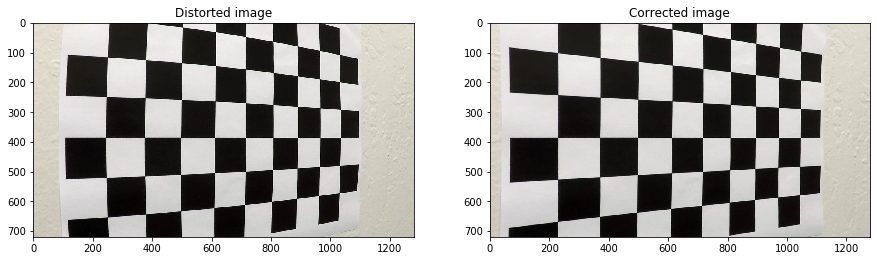

In [5]:
# Apply distortion correction
undist = helpers.undistort_image(img, {'mtx': mtx, 'dist': dist})

# Plot example
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title('Distorted image')
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax2.set_title('Corrected image')
ax2.imshow(cv2.cvtColor(undist, cv2.COLOR_BGR2RGB))
plt.show()


#### Create binary image (colors, gradients...)

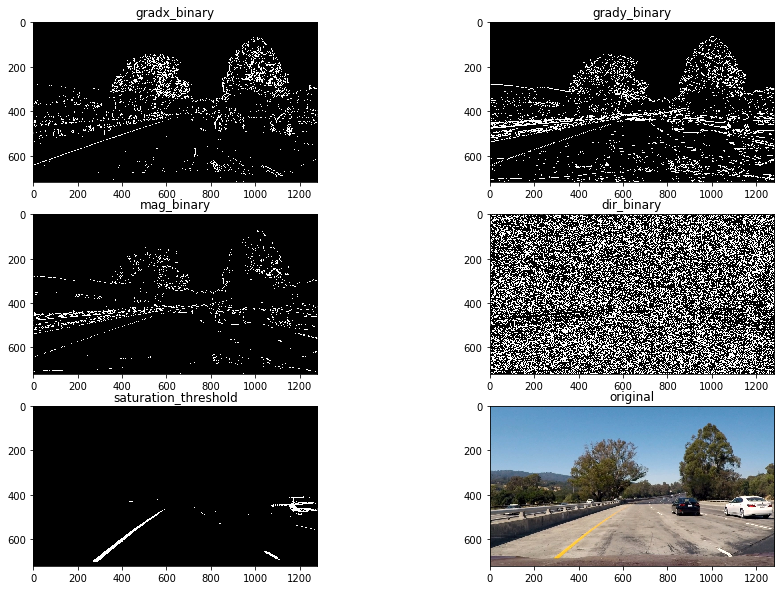

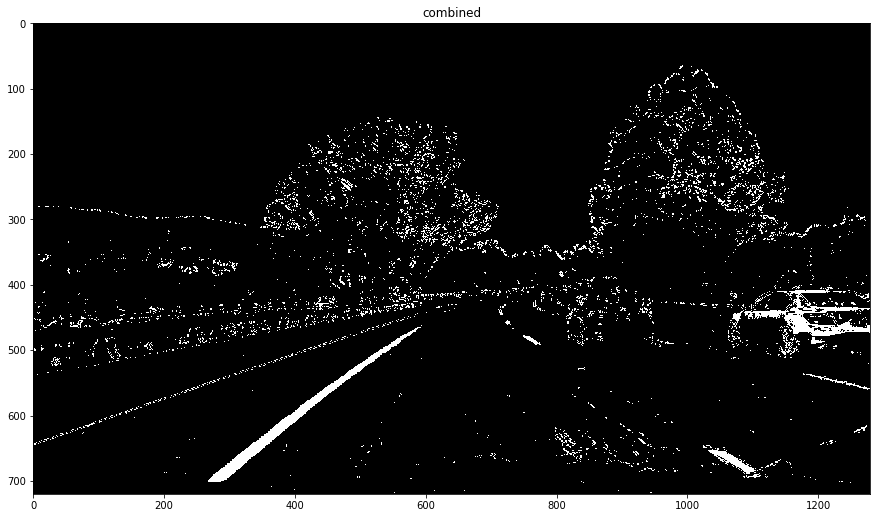

In [6]:
img = cv2.imread('test/test_images/test1.jpg')

undist = helpers.undistort_image(img, {'mtx': mtx, 'dist': dist})

kernel_size = 3

hls = cv2.cvtColor(undist, cv2.COLOR_BGR2HLS)
h, l, s = hls[:,:,0], hls[:,:,1], hls[:,:,2]

# Set saturation to 0 were not yellow
s[np.logical_or(h < 15, h > 35)] = 0
# Set saturation to 0 were brightness levels are extremely low
s[l < 50] = 0

# Absolute sobel threshold in x
gradx_binary = helpers.abs_sobel_threshold(undist, 'x', sobel_kernel=kernel_size, thresh=(20, 100))
# Absolute sobel threshold in y
grady_binary = helpers.abs_sobel_threshold(undist, 'y', sobel_kernel=kernel_size, thresh=(20, 100))
# Magnitute gradient threshold
mag_binary = helpers.mag_sobel_threshold(undist, sobel_kernel=kernel_size, thresh=(50, 100))
# Direction gradient threshold
dir_binary = helpers.dir_sobel_threshold(undist, sobel_kernel=kernel_size, thresh=(0.7, 1.3))
#Saturation threshold
saturation_threshold = helpers.saturation_threshold(s, thresh=(140, 255))
# Hue threshold
hue_threshold = helpers.saturation_threshold(h)

# Plot example
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(15, 10))
ax1.set_title('gradx_binary')
ax1.imshow(gradx_binary, cmap='gray')
ax2.set_title('grady_binary')
ax2.imshow(grady_binary, cmap='gray')
ax3.set_title('mag_binary')
ax3.imshow(mag_binary, cmap='gray')
ax4.set_title('dir_binary')
ax4.imshow(dir_binary, cmap='gray')
ax5.set_title('saturation_threshold')
ax5.imshow(saturation_threshold, cmap='gray')
ax6.set_title('original')
ax6.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

# Combined thresholds
combined = np.zeros_like(undist[:,:,0])
mask = (\
        ((gradx_binary == 1) & (grady_binary == 1))\
         | \
        ((mag_binary == 1) & (dir_binary == 1))\
         | \
        ((saturation_threshold == 1) & (hue_threshold == 1))\
       )
combined[mask] = 1

# Plot example
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
ax.set_title('combined')
ax.imshow(combined, cmap='gray')
plt.show()

#### Perspective transform

In [7]:
img_size = combined.shape[1::-1]
# Define source points
src = np.float32(
    [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
    [((img_size[0] / 6) - 10), img_size[1]],
    [(img_size[0] * 5 / 6) + 60, img_size[1]],
    [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
# Define destination points forming a rectangle
dst = np.float32(
    [[(img_size[0] / 4), 0],
    [(img_size[0] / 4), img_size[1]],
    [(img_size[0] * 3 / 4), img_size[1]],
    [(img_size[0] * 3 / 4), 0]])

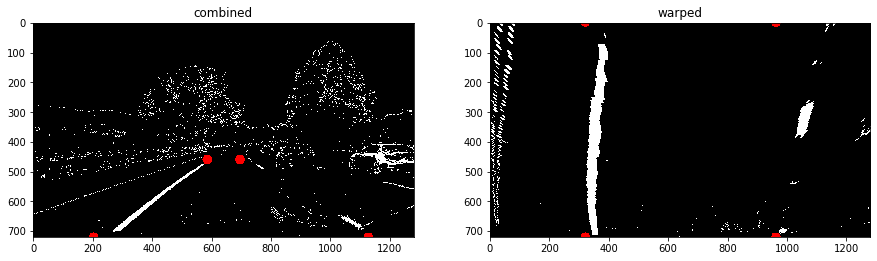

In [8]:
# Warp image (bird's eye view)
warped, M = helpers.warp_image(combined, src, dst)

# Plot combined image and warped image
combined_with_points = np.dstack((combined, combined, combined))*255
warped_with_points = np.dstack((warped, warped, warped))*255

for x, y in src:
    x, y = x.astype(int), y.astype(int)
    cv2.circle(combined_with_points, (x, y), 1, (255, 0, 0), 30)
for x, y in dst:
    x, y = x.astype(int), y.astype(int)
    cv2.circle(warped_with_points, (x, y), 1, (255, 0, 0), 30)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10))
ax1.set_title('combined')
ax1.imshow(combined_with_points)
ax2.set_title('warped')
ax2.imshow(warped_with_points)
plt.show()

#### Sliding windows

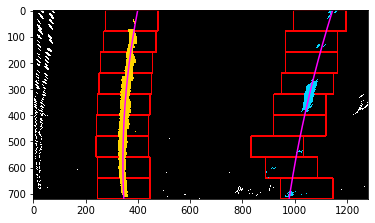

In [9]:
# Detect the lanes with sliding windows and fit polynomial
left_fit, right_fit, output_img = helpers.fit_polynomial_with_sliding_window(warped, num_windows=9,
                                                                             margin=100, min_pix=50,
                                                                             draw=True, plot=True)
plt.imshow(output_img)


#### Margin within previous lanes

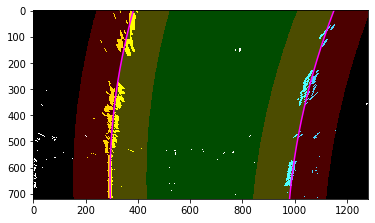

In [10]:
# Process next image in the flow
img = cv2.imread('test/test_images/test5.jpg')
undist = helpers.undistort_image(img, {'mtx': mtx, 'dist': dist})
hls = cv2.cvtColor(undist, cv2.COLOR_BGR2HLS)
l, s = hls[:,:,1], hls[:,:,2]
s[l < 20] = 0
gradx_binary = helpers.abs_sobel_threshold(undist, 'x', sobel_kernel=kernel_size, thresh=(20, 100))
grady_binary = helpers.abs_sobel_threshold(undist, 'y', sobel_kernel=kernel_size, thresh=(20, 100))
mag_binary = helpers.mag_sobel_threshold(undist, sobel_kernel=kernel_size, thresh=(30, 100))
dir_binary = helpers.dir_sobel_threshold(undist, sobel_kernel=kernel_size, thresh=(0.7, 1.3))
saturation_threshold = helpers.saturation_threshold(s, thresh=(170, 255))
combined = np.zeros_like(undist[:,:,0])
mask = (\
        (gradx_binary == 1) & (grady_binary == 1))\
         | \
        ((mag_binary == 1) & (dir_binary == 1)\
         | \
        (saturation_threshold == 1)\
       )
combined[mask] = 1
warped, _ = helpers.warp_image(combined, M=M)

# Detect the lanes on the next frame with previous polynomial and margin
left_fit, right_fit, output_img = helpers.fit_polynomial_with_previous_coefficients(warped,
                                                                                    left_fit, right_fit,
                                                                                    margin=140,
                                                                                    draw=True, plot=True)
plt.imshow(output_img)


#### Radius of curve

In [11]:
# Calculate curve radius
left_curve_radius, right_curve_radius, avg_radius = helpers.calculate_curve_radius(warped.shape[0], left_fit, right_fit)
print(f"Left lane: {int(left_curve_radius)} m")
print(f"Right lane: {int(right_curve_radius)} m")
print(f"Average: {int(avg_radius)} m")


Left lane: 2312 m
Right lane: 2500 m
Average: 2406 m


#### Result

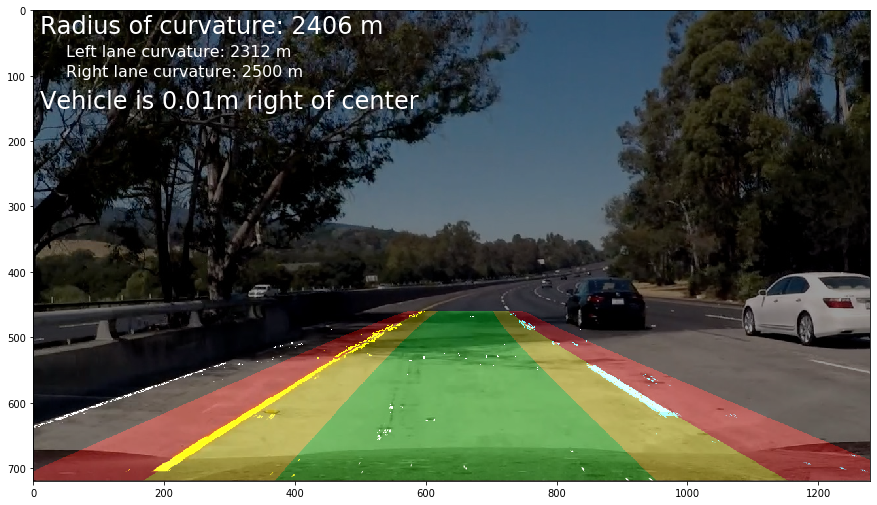

In [12]:
# Warp the lane boundaries back to the original perspective
unwarped, _ = helpers.warp_image(output_img, dst, src)
img_with_boundaries = cv2.addWeighted(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), .6, unwarped, 1, 0)

# Calculate car position on x axis in the lane
left_base = left_fit[0]*img.shape[0]**2 + left_fit[1]*img.shape[0] + left_fit[2]
right_base = right_fit[0]*img.shape[0]**2 + right_fit[1]*img.shape[0] + right_fit[2]
center = (right_base + left_base) / 2
x_pos = (img.shape[1]//2 - center) * 3.7/700 # calculate x position and convert to real world meters

fig, ax = plt.subplots(1, 1, figsize=(15,10))
ax.text(10, 35,
        f"Radius of curvature: {avg_radius:.0f} m", color='white', fontsize=24)
ax.text(50, 70,
        f"Left lane curvature: {left_curve_radius:.0f} m", color='white', fontsize=16)
ax.text(50, 100,
        f"Right lane curvature: {right_curve_radius:.0f} m", color='white', fontsize=16)
ax.text(10, 150,
        f"Vehicle is {x_pos:.2f}m {'left' if x_pos < 0 else 'right'} of center",
        color='white', fontsize=24)
ax.imshow(img_with_boundaries)


## Video pipeline

#### Define hyperparameters for pipeline

In [13]:
hyperparameters = {
            'undistort': {
                'mtx': mtx,
                'dist': dist
            },
            'saturation_brightness_min': 50,
            'abs_sobel_threshold_x': {
                'kernel_size': 3,
                'thresh': (20, 100)
            },
            'abs_sobel_threshold_y': {
                'kernel_size': 3,
                'thresh': (20, 100)
            },
            'mag_sobel_threshold': {
                'kernel_size': 3,
                'thresh': (50, 100)
            },
            'dir_sobel_threshold': {
                'kernel_size': 3,
                'thresh': (0.7, 1.3)
            },
            'saturation_threshold': {
                'thresh': (130, 255)
            },
            'warp': {
                'src': src,
                'dst': dst
            },
            'poly_sliding_window': {
                'num_windows': 9,
                'margin': 100,
                'min_pix': 50
            },
            'poly_previous': {
                'margin': 80
            },
            'curve_radius': {
                'ym_per_pix': 30/720,
                'xm_per_pix': 3.7/700
            },
            'avg_radius_num_frames': 20
        }

#### Process project video

In [14]:
video_path = "test/test_videos/project_video.mp4"
output_video_path = os.path.join(output_videos_dir, f"processed_{os.path.basename(video_path)}")

%time helpers.video_pipeline(video_path, output_video_path, hyperparameters=hyperparameters)


t:   0%|          | 2/1260 [00:00<01:41, 12.37it/s, now=None]

Moviepy - Building video output_videos/processed_project_video.mp4.
Moviepy - Writing video output_videos/processed_project_video.mp4



Moviepy - Done !
Moviepy - video ready output_videos/processed_project_video.mp4
CPU times: user 18min 51s, sys: 29 s, total: 19min 20s
Wall time: 4min 30s


In [15]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_video_path))

#### Process challenge video

In [16]:
video_path = "test/test_videos/challenge_video.mp4"
output_video_path = os.path.join(output_videos_dir, f"processed_{os.path.basename(video_path)}")

%time helpers.video_pipeline(video_path, output_video_path, hyperparameters=hyperparameters)


t:   0%|          | 2/485 [00:00<00:36, 13.24it/s, now=None]

Moviepy - Building video output_videos/processed_challenge_video.mp4.
Moviepy - Writing video output_videos/processed_challenge_video.mp4



t:  28%|██▊       | 135/485 [00:21<01:05,  5.37it/s, now=None]

The function failed to fit a lane. Falling back to sliding windows.


t:  28%|██▊       | 136/485 [00:22<01:09,  5.04it/s, now=None]

The function failed to fit a lane. Falling back to sliding windows.


Moviepy - Done !
Moviepy - video ready output_videos/processed_challenge_video.mp4
CPU times: user 6min 58s, sys: 10.2 s, total: 7min 9s
Wall time: 1min 35s


In [17]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_video_path))

#### Process harder challenge video

In [18]:
video_path = "test/test_videos/harder_challenge_video.mp4"
output_video_path = os.path.join(output_videos_dir, f"processed_{os.path.basename(video_path)}")

%time helpers.video_pipeline(video_path, output_video_path, hyperparameters=hyperparameters)


t:   0%|          | 2/1199 [00:00<01:30, 13.30it/s, now=None]

Moviepy - Building video output_videos/processed_harder_challenge_video.mp4.
Moviepy - Writing video output_videos/processed_harder_challenge_video.mp4



Moviepy - Done !
Moviepy - video ready output_videos/processed_harder_challenge_video.mp4
CPU times: user 18min 5s, sys: 28.4 s, total: 18min 33s
Wall time: 4min 21s


In [19]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_video_path))